# ПЗ 8


# Задание  
На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN и (RNN -> CNN)
4. сдлать выводы что получилось лучше

In [3]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 8.2 MB 45.2 MB/s 


In [5]:
#  Возьмем датасет с прошлого занятия
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_val = pd.read_csv("val.csv")

In [7]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [8]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
#import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, concatenate, Flatten, add, MaxPool1D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Masking, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping  


In [10]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [11]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [12]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [13]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle('Horizontally stacked subplots')
       
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'test'], loc='upper left')


# LSTM NN 1

In [14]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = LSTM(64, return_sequences=True)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 27, 30)            7743240   
_________________________________________________________________
lstm (LSTM)                  (None, 27, 64)            24320     
_________________________________________________________________
flatten (Flatten)            (None, 1728)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                110656    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

Epoch 1/25
709/709 [==============================] - 108s 144ms/step - loss: 0.5329 - accuracy: 0.7228 - val_loss: 0.4988 - val_accuracy: 0.7518
Epoch 2/25
709/709 [==============================] - 99s 139ms/step - loss: 0.2873 - accuracy: 0.8823 - val_loss: 0.6043 - val_accuracy: 0.7383
Epoch 3/25
709/709 [==============================] - 99s 140ms/step - loss: 0.1292 - accuracy: 0.9507 - val_loss: 0.8131 - val_accuracy: 0.7265
Epoch 4/25
709/709 [==============================] - 99s 140ms/step - loss: 0.0731 - accuracy: 0.9733 - val_loss: 0.9619 - val_accuracy: 0.7258


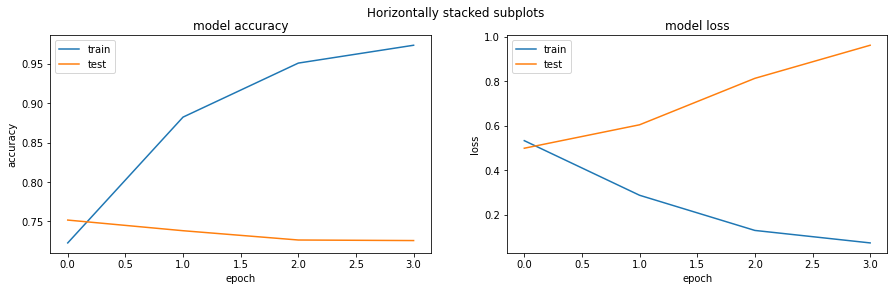

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [16]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 5s 7ms/step - loss: 0.4988 - accuracy: 0.7518


[0.49884751439094543, 0.7517964839935303]

# LSTM NN 2

In [17]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

xbi = Bidirectional(LSTM(15, return_sequences=True))(x)
x = add([x, xbi])

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 30)       7743240     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 27, 30)       5520        embedding_1[0][0]                
__________________________________________________________________________________________________
add (Add)                       (None, 27, 30)       0           embedding_1[0][0]                
                                                                 bidirectional[0][0]        

Epoch 1/25
709/709 [==============================] - 142s 192ms/step - loss: 0.5329 - accuracy: 0.7230 - val_loss: 0.4988 - val_accuracy: 0.7503
Epoch 2/25
709/709 [==============================] - 135s 190ms/step - loss: 0.2706 - accuracy: 0.8898 - val_loss: 0.5799 - val_accuracy: 0.7380
Epoch 3/25
709/709 [==============================] - 134s 189ms/step - loss: 0.1062 - accuracy: 0.9611 - val_loss: 0.7975 - val_accuracy: 0.7313
Epoch 4/25
709/709 [==============================] - 135s 190ms/step - loss: 0.0533 - accuracy: 0.9813 - val_loss: 0.9869 - val_accuracy: 0.7269


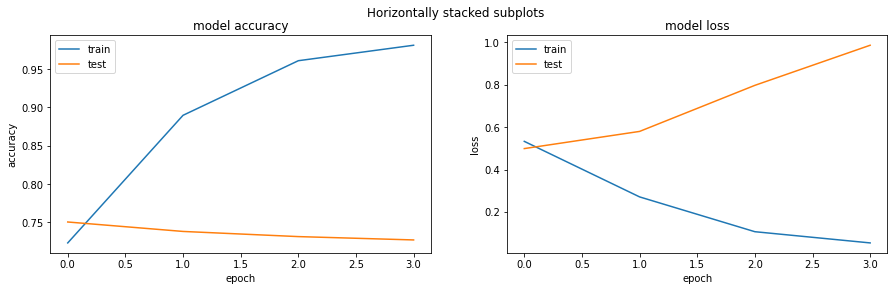

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [19]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 11s 15ms/step - loss: 0.4988 - accuracy: 0.7503


[0.49880868196487427, 0.7503416538238525]

# LSTM NN 3

In [20]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

xbi = LSTM(30, return_sequences=True)(x)
x = add([x, xbi])
xbi = LSTM(30, return_sequences=True)(x)
x = add([x, xbi])
xbi = LSTM(30, return_sequences=True)(x)
x = add([x, xbi])


x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 27, 30)       7743240     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 27, 30)       7320        embedding_2[0][0]                
__________________________________________________________________________________________________
add_1 (Add)                     (None, 27, 30)       0           embedding_2[0][0]                
                                                                 lstm_2[0][0]               

Epoch 1/25
709/709 [==============================] - 198s 266ms/step - loss: 0.5304 - accuracy: 0.7264 - val_loss: 0.5031 - val_accuracy: 0.7485
Epoch 2/25
709/709 [==============================] - 188s 265ms/step - loss: 0.2690 - accuracy: 0.8902 - val_loss: 0.5828 - val_accuracy: 0.7391
Epoch 3/25
709/709 [==============================] - 187s 264ms/step - loss: 0.1073 - accuracy: 0.9603 - val_loss: 0.8284 - val_accuracy: 0.7279
Epoch 4/25
709/709 [==============================] - 187s 264ms/step - loss: 0.0572 - accuracy: 0.9793 - val_loss: 0.9765 - val_accuracy: 0.7227


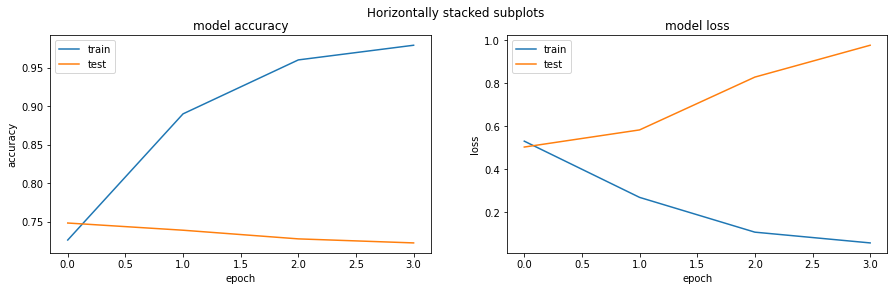

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [22]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 12s 17ms/step - loss: 0.5031 - accuracy: 0.7485


[0.5030924081802368, 0.748490035533905]

# CNN 1

In [23]:
#dim = int((word_count)**(1/2))
dim = 30

inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=dim,
              trainable=True,
              mask_zero=True)(inputs)

x = Conv1D(128, 3, activation='relu')(x)

x = GlobalMaxPool1D()(x)
#x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 128)           11648     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65  

Epoch 1/25
709/709 [==============================] - 81s 74ms/step - loss: 0.5416 - accuracy: 0.7151 - val_loss: 0.5078 - val_accuracy: 0.7469
Epoch 2/25
709/709 [==============================] - 51s 72ms/step - loss: 0.2880 - accuracy: 0.8828 - val_loss: 0.5832 - val_accuracy: 0.7417
Epoch 3/25
709/709 [==============================] - 51s 72ms/step - loss: 0.1014 - accuracy: 0.9648 - val_loss: 0.8188 - val_accuracy: 0.7277
Epoch 4/25
709/709 [==============================] - 51s 72ms/step - loss: 0.0422 - accuracy: 0.9864 - val_loss: 1.0054 - val_accuracy: 0.7284


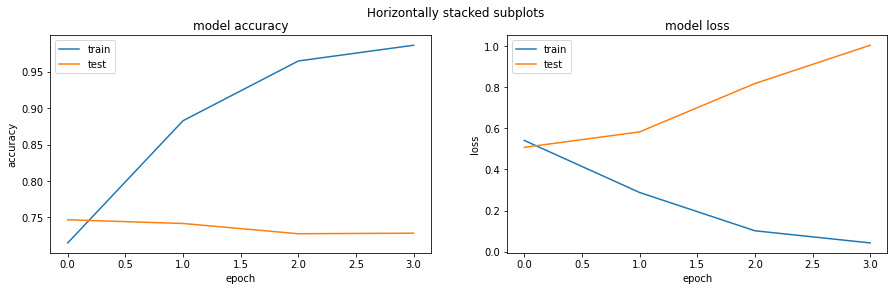

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [25]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 2s 2ms/step - loss: 0.5078 - accuracy: 0.7469


[0.5078473091125488, 0.7468588948249817]

# CNN 2

In [26]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = Conv1D(filters, 3, padding="same")(x)
        x = Activation(activation)(x)
    x = Conv1D(filters, 3, padding="same")(x)
    x = add([x, s])
    x = Activation(activation)(x)
    return MaxPool1D(pool_size=2, strides=2)(x)



def build_model(X_train):
    inputs = Input(shape=(X_train.shape[1],))
    
    x = tf.keras.layers.Reshape((27, 1))(inputs)

    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)

    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)

    outputs = Dense(1, activation="sigmoid", name="output")(x)

    
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model 


In [27]:
model = build_model(X_train)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 27, 1)        0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 27, 16)       64          reshape[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 27, 16)       0           conv1d_2[0][0]                   
____________________________________________________________________________________________

Epoch 1/25
709/709 [==============================] - 6s 7ms/step - loss: 19.9516 - accuracy: 0.5321 - val_loss: 1.9619 - val_accuracy: 0.5074
Epoch 2/25
709/709 [==============================] - 5s 7ms/step - loss: 2.0519 - accuracy: 0.5447 - val_loss: 0.9300 - val_accuracy: 0.5039
Epoch 3/25
709/709 [==============================] - 4s 6ms/step - loss: 0.8781 - accuracy: 0.5507 - val_loss: 0.7184 - val_accuracy: 0.5107
Epoch 4/25
709/709 [==============================] - 4s 6ms/step - loss: 0.7066 - accuracy: 0.5621 - val_loss: 0.7179 - val_accuracy: 0.5390
Epoch 5/25
709/709 [==============================] - 4s 6ms/step - loss: 0.6775 - accuracy: 0.5813 - val_loss: 0.7185 - val_accuracy: 0.5446
Epoch 6/25
709/709 [==============================] - 4s 6ms/step - loss: 0.6744 - accuracy: 0.5825 - val_loss: 0.7047 - val_accuracy: 0.5464
Epoch 7/25
709/709 [==============================] - 4s 6ms/step - loss: 0.6714 - accuracy: 0.5865 - val_loss: 0.7387 - val_accuracy: 0.5436
Epoch

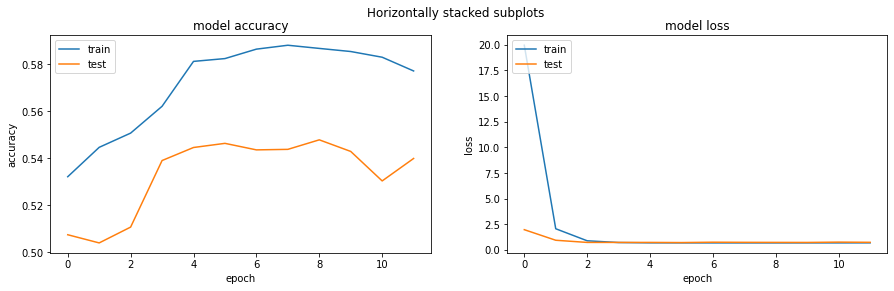

In [28]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [29]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 2s 3ms/step - loss: 0.7208 - accuracy: 0.5479


[0.7208196520805359, 0.5478551983833313]

# CNN+LSTM

In [30]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = (Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))(x)

x = LSTM(64, return_sequences=True)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 27, 64)            5824      
_________________________________________________________________
lstm_5 (LSTM)                (None, 27, 64)            33024     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                110656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 56s 75ms/step - loss: 0.5306 - accuracy: 0.7239 - val_loss: 0.4977 - val_accuracy: 0.7540
Epoch 2/25
709/709 [==============================] - 54s 76ms/step - loss: 0.2671 - accuracy: 0.8911 - val_loss: 0.6410 - val_accuracy: 0.7350
Epoch 3/25
709/709 [==============================] - 53s 75ms/step - loss: 0.1044 - accuracy: 0.9617 - val_loss: 0.8109 - val_accuracy: 0.7304
Epoch 4/25
709/709 [==============================] - 55s 77ms/step - loss: 0.0479 - accuracy: 0.9834 - val_loss: 1.1656 - val_accuracy: 0.7227


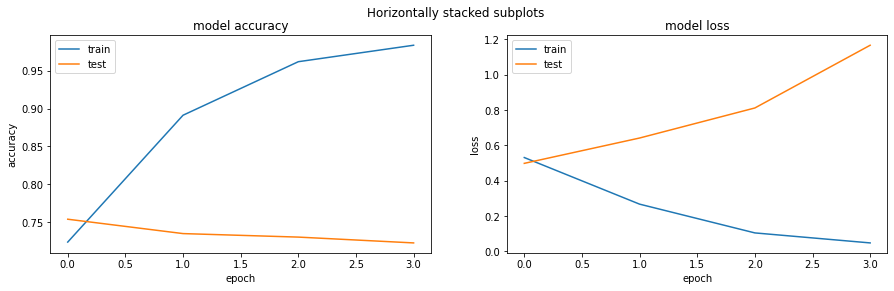

In [31]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [32]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 2s 3ms/step - loss: 0.4977 - accuracy: 0.7540


[0.49770060181617737, 0.7540007829666138]

# ConvLSTM2D

In [33]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)


x = tf.keras.layers.Reshape((27, 30, 1, 1))(x)
x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', padding="same")(x)


x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
reshape_1 (Reshape)          (None, 27, 30, 1, 1)      0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 30, 1, 64)         33536     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                122944    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 185s 256ms/step - loss: 0.5493 - accuracy: 0.7120 - val_loss: 0.5106 - val_accuracy: 0.7437
Epoch 2/25
709/709 [==============================] - 182s 256ms/step - loss: 0.3259 - accuracy: 0.8655 - val_loss: 0.5730 - val_accuracy: 0.7453
Epoch 3/25
709/709 [==============================] - 180s 254ms/step - loss: 0.1605 - accuracy: 0.9404 - val_loss: 0.7572 - val_accuracy: 0.7287
Epoch 4/25
709/709 [==============================] - 180s 254ms/step - loss: 0.0870 - accuracy: 0.9690 - val_loss: 0.9861 - val_accuracy: 0.7272
Epoch 5/25
709/709 [==============================] - 179s 252ms/step - loss: 0.0474 - accuracy: 0.9825 - val_loss: 1.3049 - val_accuracy: 0.7224


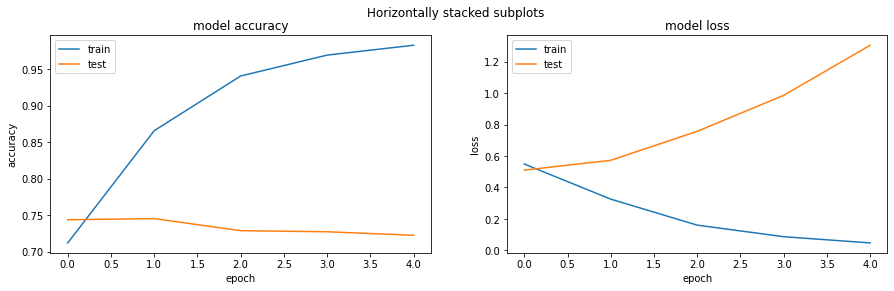

In [34]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [35]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 13s 18ms/step - loss: 0.5730 - accuracy: 0.7453


[0.5729637742042542, 0.7452718019485474]

# LSTM + CNN

In [36]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)


x = LSTM(64, return_sequences=True)(x)
x = (Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
lstm_6 (LSTM)                (None, 27, 64)            24320     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 27, 64)            12352     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                110656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 104s 142ms/step - loss: 0.5316 - accuracy: 0.7253 - val_loss: 0.5038 - val_accuracy: 0.7477
Epoch 2/25
709/709 [==============================] - 100s 141ms/step - loss: 0.2846 - accuracy: 0.8826 - val_loss: 0.5947 - val_accuracy: 0.7394
Epoch 3/25
709/709 [==============================] - 101s 142ms/step - loss: 0.1317 - accuracy: 0.9504 - val_loss: 0.8722 - val_accuracy: 0.7307
Epoch 4/25
709/709 [==============================] - 99s 140ms/step - loss: 0.0710 - accuracy: 0.9740 - val_loss: 1.0092 - val_accuracy: 0.7312


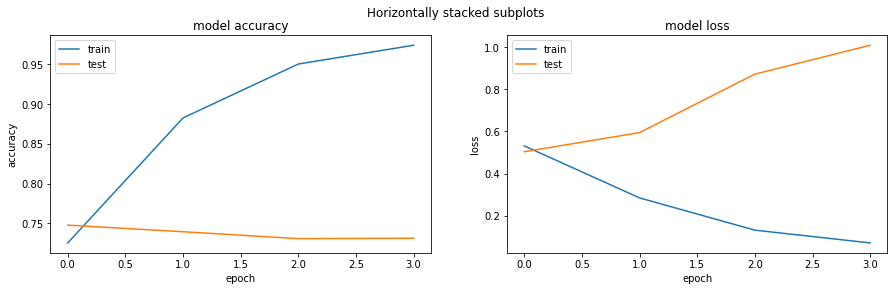

In [37]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [38]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 5s 7ms/step - loss: 0.5038 - accuracy: 0.7477


[0.5037987232208252, 0.7476524114608765]

# Выводы.

Лучше всего сработали (в порядке убывания результата) следующие архитектуры:

    1. LSTM + CNN
    2. CNN + LSTM
    3. Стекинг из LSTM с residual connection.
    
При этом их результаты не сильно отличались и однозначно сказать что какая то архитектура лучше других нельзя.

__P.S.__ Качество на тесте практически всех моделей падало после первой же эпохи. Это говорит о возможном переобучении уже в течении выполнения первой эпохи. Может быть имело смысл уменьшить размер датасета на трейне или хотя бы размер батча.